# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


In [1]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_test = pd.read_json('../data/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)

In [3]:
df_train = pd.read_json('../data/train.json') # this is a dataframe

In [4]:
band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
#print(band_1)
#print(band_2)

In [5]:
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

In [6]:
band_1_linear = decibel_to_linear(band_1)
band_2_linear = decibel_to_linear(band_2)

E:\InstalledSoftware\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


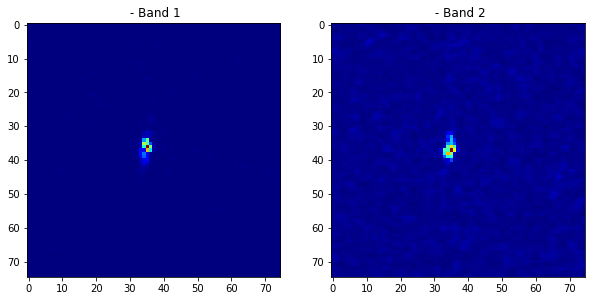

In [14]:
#print(band_1_linear)
#print(band_2_linear)
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title(' - Band 1')
ax.imshow(band_1_linear[0],cmap='jet')
ax = fig.add_subplot(1,2,2)
ax.set_title(' - Band 2')
ax.imshow(band_2_linear[0],cmap='jet')
plt.show()

In [7]:
# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
        # band: SAR data to be despeckled (already reshaped into image dimensions)
        # window: descpeckling filter window (tuple)
        # default noise variance = 0.25
        # assumes noise mean = 0
    
        mean_window = uniform_filter(band, window)
        mean_sqr_window = uniform_filter(band**2, window)
        var_window = mean_sqr_window - mean_window**2

        weights = var_window / (var_window + var_noise)
        band_filtered = mean_window + weights*(band - mean_window)
        return band_filtered

In [10]:
windows = [2, 4, 8] # can be tuple too if not symetric
noise_var = np.array([1, 2, 4])

title_str_1 = ' Band 1\nWindow: {}, Noise Var: {}'
title_str_2 = ' Band 2\nWindow: {}, Noise Var: {}'

noise_var_1 = np.round(np.var(band_1_linear)*noise_var,10)
noise_var_2 = np.round(np.var(band_2_linear)*noise_var,10)

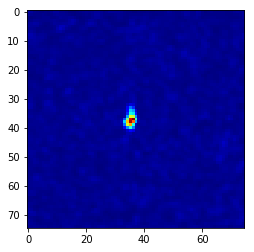

In [12]:
# import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
plt.imshow(lee_filter(band_2_linear[0], windows[0], noise_var_1[0]),cmap='jet')    
plt.show()

In [36]:
def get_scaled_imgs(df):
    imgs = []

    band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    band_1_linear = decibel_to_linear(band_1)
    band_2_linear = decibel_to_linear(band_2)
    
    for i, row in df.iterrows():

        band_1 = lee_filter(band_1_linear[i], windows[0], noise_var_1[0])
        band_2 = lee_filter(band_2_linear[i], windows[0], noise_var_1[0])
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        #plt.imshow(lee_filter(band_2_linear[0], windows[0], noise_var_1[0]),cmap='jet')    

        #make 75x75 image
        #band_1 = np.array(row['band_1']).reshape(75, 75)
        #band_2 = np.array(row['band_2']).reshape(75, 75)
        #band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))
        #imgs.append(i)

    return np.array(imgs)

In [43]:
Xtrain = get_scaled_imgs(df_train)
print(Xtrain.shape)

(1604, 75, 75, 3)


In [44]:
Ytrain = np.array(df_train['is_iceberg'])

In [45]:
df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

In [46]:
Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [47]:
def get_more_images(images):
    
    image_rot90 = []
    image_rot180 = []
    image_rot270 = []
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
        
        # rotate 90
        band_1_rot90 = np.rot90(band_1)
        band_2_rot90 = np.rot90(band_2)
        band_3_rot90 = np.rot90(band_3)
        image_rot90.append(np.dstack((band_1_rot90, band_2_rot90, band_3_rot90)))
        
        # rotate 180
        band_1_rot180 = np.rot90(band_1_rot90)
        band_2_rot180 = np.rot90(band_2_rot90)
        band_3_rot180 = np.rot90(band_3_rot90)
        image_rot180.append(np.dstack((band_1_rot180, band_2_rot180, band_3_rot180)))
        
        # rotate 270
        band_1_rot270 = np.rot90(band_1_rot180)
        band_2_rot270 = np.rot90(band_2_rot180)
        band_3_rot270 = np.rot90(band_3_rot180)
        image_rot270.append(np.dstack((band_1_rot270, band_2_rot270, band_3_rot270)))
        
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
    rot90 = np.array(image_rot90)
    rot180 = np.array(image_rot180)
    rot270 = np.array(image_rot270)
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    #images = np.concatenate((images, rot90, rot180, rot270, mirrorlr, mirrorud))
    images = np.concatenate((images, mirrorlr, mirrorud))
    
    return images

In [48]:
Xtr_more = get_more_images(Xtrain) 

In [49]:
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))
#Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain,Ytrain,Ytrain,Ytrain))

In [65]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(5, 5),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [66]:
model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('../models/model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 71, 71, 64)        4864      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 128)       147584    
__________

In [59]:
#timeline=model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=8, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1)
timeline=model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=500, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1)


Train on 3971 samples, validate on 442 samples
Epoch 1/500
3971/3971 [==============================] - 149s 37ms/step - loss: 0.5501 - acc: 0.7192 - val_loss: 0.3742 - val_acc: 0.8190
Epoch 2/500
3971/3971 [==============================] - 146s 37ms/step - loss: 0.3916 - acc: 0.8046 - val_loss: 0.3309 - val_acc: 0.8484
Epoch 3/500
3971/3971 [==============================] - 144s 36ms/step - loss: 0.3461 - acc: 0.8381 - val_loss: 0.3169 - val_acc: 0.8484
Epoch 4/500
3971/3971 [==============================] - 145s 37ms/step - loss: 0.3133 - acc: 0.8512 - val_loss: 0.2875 - val_acc: 0.8846
Epoch 5/500
3971/3971 [==============================] - 147s 37ms/step - loss: 0.2909 - acc: 0.8638 - val_loss: 0.3600 - val_acc: 0.8326
Epoch 6/500
3971/3971 [==============================] - 145s 37ms/step - loss: 0.3088 - acc: 0.8623 - val_loss: 0.3745 - val_acc: 0.8348
Epoch 7/500
3971/3971 [==============================] - 147s 37ms/step - loss: 0.2470 - acc: 0.8907 - val_loss: 0.2724 - val

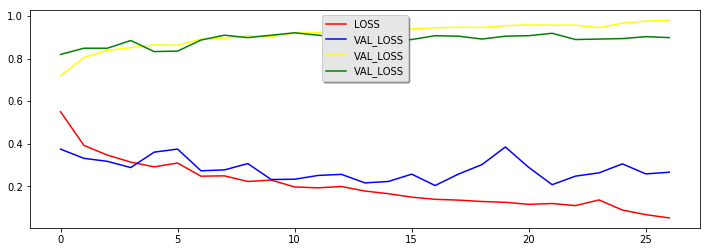

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,4))

plt.plot(timeline.history['loss'], color='red', label='LOSS')
plt.plot(timeline.history['val_loss'], color='blue', label='VAL_LOSS')
plt.plot(timeline.history['acc'], color='yellow', label='VAL_LOSS')
plt.plot(timeline.history['val_acc'], color='green', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [61]:
model.load_weights(filepath = '../models/model.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 15s 10ms/step
Train score: 0.0871189760942
Train accuracy: 0.966689326988


In [62]:
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission)


            id    is_iceberg
0     5941774d  7.128880e-02
1     4023181e  7.801189e-01
2     b20200e4  6.327574e-04
3     e7f018bb  9.999989e-01
4     4371c8c3  9.433751e-01
5     a8d9b1fd  4.184909e-01
6     29e7727e  2.353549e-02
7     92a51ffb  1.000000e+00
8     c769ac97  3.565442e-05
9     aee0547d  5.782890e-07
10    565b28ac  6.269059e-08
11    e04e9775  9.991031e-01
12    8e8161d1  7.543321e-05
13    4cf4d256  8.101206e-01
14    139e5324  8.891463e-04
15    f156976f  1.691335e-03
16    68a117cc  1.742649e-03
17    d9aa7a56  2.061114e-01
18    9005b143  3.429532e-03
19    5f6d3988  9.984611e-01
20    9ad70954  1.249166e-02
21    b9087b9e  6.976984e-01
22    a39a1427  9.559980e-01
23    82fbe8ed  4.658346e-01
24    1fae4879  1.158368e-06
25    6dd8f13d  1.619091e-01
26    bbad5958  4.002581e-01
27    54527583  6.526928e-02
28    be8fa29c  2.884433e-05
29    81a3328f  9.999917e-01
...        ...           ...
8394  8ae30ce6  1.894799e-03
8395  de27ed88  5.146395e-02
8396  66d5196f

In [64]:
submission.to_csv('../submission/submission18.csv', index=False)